In [2]:
# Discription
# This is designed to predict plasma current based off of highspeed image data. Checks with ip data for target accuracy

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import fsspec, os
import scipy as sp
import PIL
from PIL import Image
import random
import os
import glob
import re

In [4]:
# Define shot list
shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
             119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
             119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
             119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768,
             119769]

# Load IP data from .npy files
file_path_ip = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/ip_Data/'
file_path_tiff = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/Training/Input Data/Shots/'

TARGET_FRAME_COUNT = 800
CAMERA_DEPTH = 65535.0 # 2^16

In [5]:
# Helper functions for data processing
def determine_frame_ratio(num_frames, target_frames=TARGET_FRAME_COUNT):
    """
    Determines the frame ratio needed to downsample the data to target_frames.
    Returns the ratio and the actual number of frames after downsampling.
    """
    ratio = max(1, num_frames // target_frames)
    actual_frames = num_frames // ratio
    return ratio, actual_frames

def process_shot_data(folder_path, target_frame_count=TARGET_FRAME_COUNT, max_pixel_value=CAMERA_DEPTH):
    """
    Process a single shot's data with automatic frame rate handling.
    Returns: 2D data, cut 2D data, and flat data for the shot
    """
    tiff_files = sorted(glob.glob(os.path.join(folder_path, "*.tiff")))
    num_frames = len(tiff_files)
    
    if num_frames == 0:
        raise ValueError(f"No TIFF files found in {folder_path}")
    
    frame_ratio, actual_frames = determine_frame_ratio(num_frames, target_frame_count)
    
    # Initialize shot lists
    flat_shot = []
    shot_2d = []
    cut_shot = []
    
    # Process TIFF files with dynamic frame ratio
    for j, tiff_file in enumerate(tiff_files):
        if j % frame_ratio == 0 and len(shot_2d) < target_frame_count:
            try:
                im = Image.open(tiff_file)
                im = np.array(im, dtype=np.float32)
                # Normalize to [0,1] range
                im = (im - im.min()) / (im.max() - im.min())
                flat_im = im.reshape(-1)
                cut_2d = im[:, 48:-48]
                
                shot_2d.append(im)
                flat_shot.append(flat_im)
                cut_shot.append(cut_2d)
                
            except Exception as e:
                print(f"Error loading {tiff_file}: {e}")
                continue
    
    return np.array(shot_2d), np.array(cut_shot), np.array(flat_shot)

def process_all_shots(shot_list, base_path, target_frame_count=TARGET_FRAME_COUNT):
    """
    Process multiple shots with automatic frame rate handling
    """
    training_data_2D = []
    cut_training_data_2D = []
    flat_training_data = []
    
    for shot in shot_list:
        folder_path = os.path.join(base_path, str(shot), 'CAM-26731/tiff/')
        try:
            shot_2d, cut_2d, flat_data = process_shot_data(folder_path, target_frame_count)
            
            if len(shot_2d) == target_frame_count:
                training_data_2D.append(shot_2d)
                cut_training_data_2D.append(cut_2d)
                flat_training_data.append(flat_data)
            else:
                print(f"Shot {shot} produced {len(shot_2d)} frames, expected {target_frame_count}. Skipping.")
                
        except Exception as e:
            print(f"Error processing shot {shot}: {e}")
            continue
    
    return (np.array(training_data_2D), 
            np.array(cut_training_data_2D), 
            np.array(flat_training_data))
def load_ip_data(shot_list, file_path):
    ip_data = []
    for shot in shot_list:
        try:
            shot_data = np.load(os.path.join(file_path, f'{shot}ip.npy'))
            ip_data.append(shot_data)
        except FileNotFoundError:
            print(f"Warning: Could not find IP data for shot {shot}")
    return np.array(ip_data)

IP data shape: (37, 800, 1)


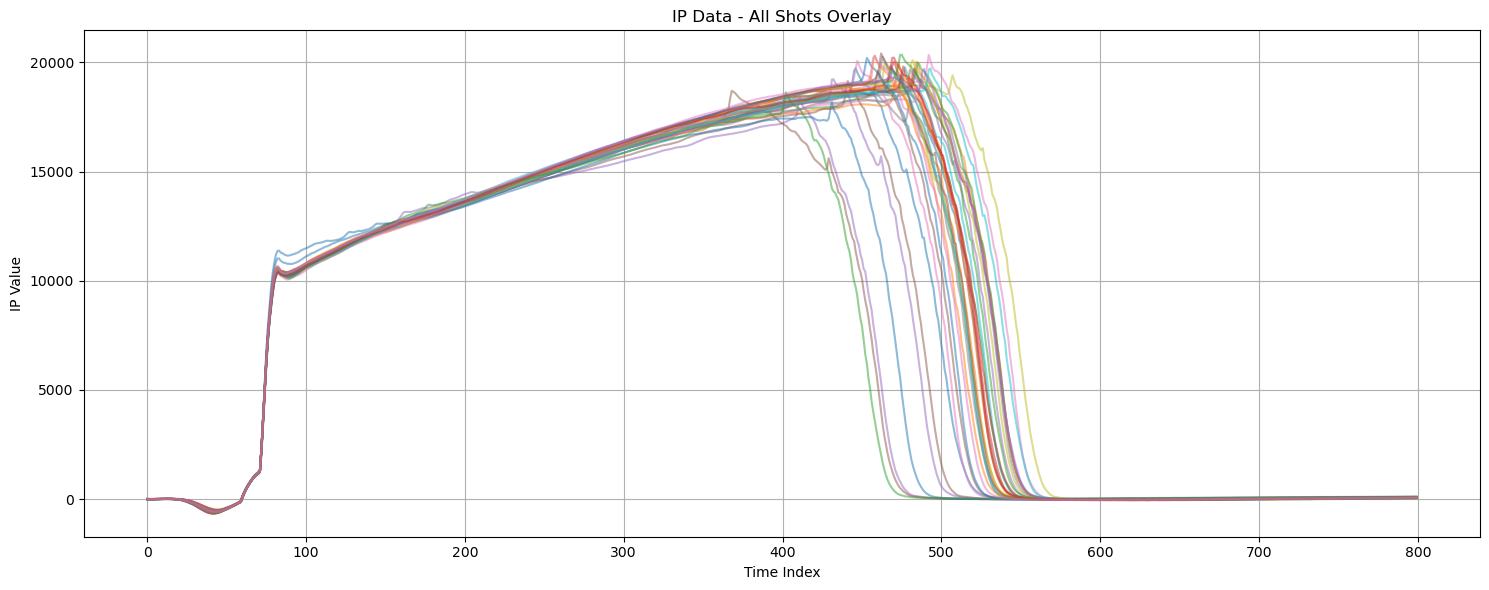

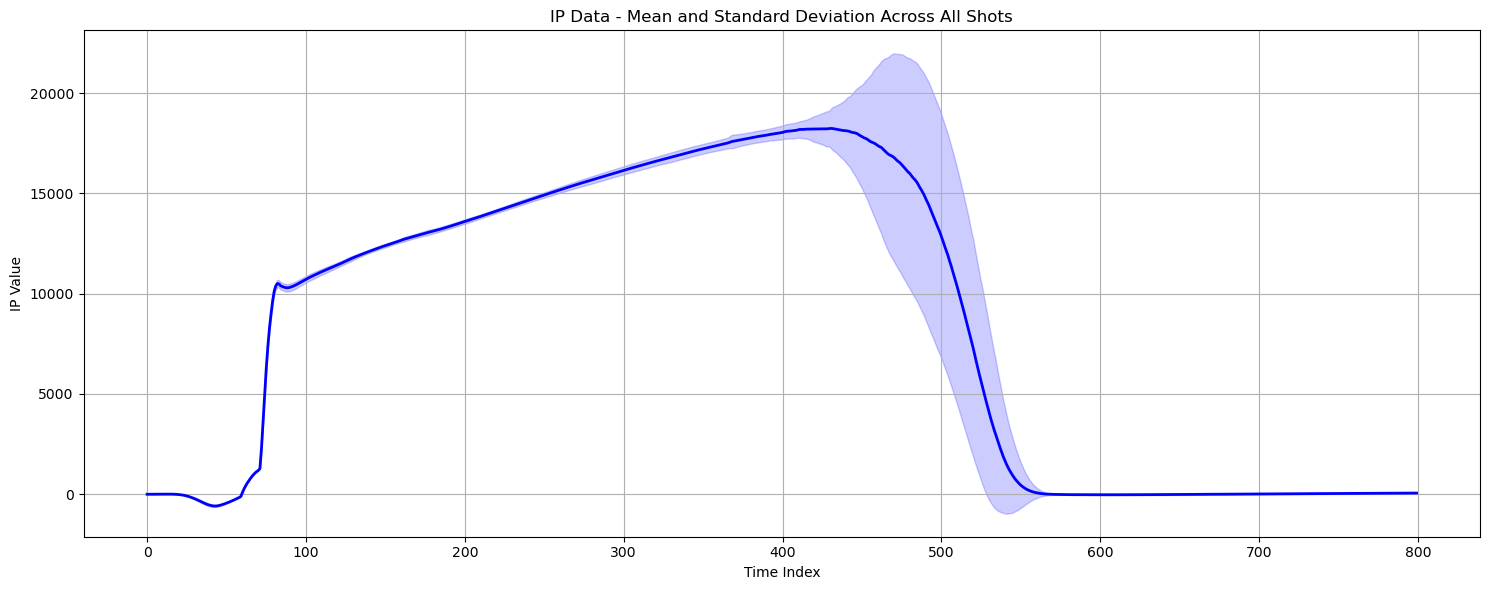

In [105]:
# Function to format IP data
def format_ip_data(data, target_length=TARGET_FRAME_COUNT):
    """Format plasma current data to match target length through downsampling"""
    # Convert to array and get frame ratio
    data = np.asarray(data, dtype=float)
    frame_ratio = data[0].shape[0] // target_length
    
    # Reshape and downsample in one go
    data = np.reshape(data, (len(data), -1, 1))
    data = data[:,::frame_ratio,:]
    data = data[:,:target_length,:]
    return data

# Load IP data
ip_data = load_ip_data(shot_list, file_path_ip)
formatted_ip_data = format_ip_data(ip_data)

print("IP data shape:", formatted_ip_data.shape)

# Plot all shots overlaid
plt.figure(figsize=(15, 6))
for i, shot_num in enumerate(shot_list):
    plt.plot(formatted_ip_data[i, :, 0], alpha=0.5)
plt.title('IP Data - All Shots Overlay')
plt.xlabel('Time Index')
plt.ylabel('IP Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create plot showing mean and standard deviation
plt.figure(figsize=(15, 6))
mean_ip = np.mean(formatted_ip_data[:, :, 0], axis=0)
std_ip = np.std(formatted_ip_data[:, :, 0], axis=0)

plt.plot(mean_ip, 'b-', label='Mean IP', linewidth=2)
plt.fill_between(range(len(mean_ip)), 
                mean_ip - std_ip, 
                mean_ip + std_ip, 
                color='b', alpha=0.2, 
                label='±1 Std Dev')
plt.title('IP Data - Mean and Standard Deviation Across All Shots')
plt.xlabel('Time Index')
plt.ylabel('IP Value')
plt.grid(True)
plt.tight_layout()
plt.show()


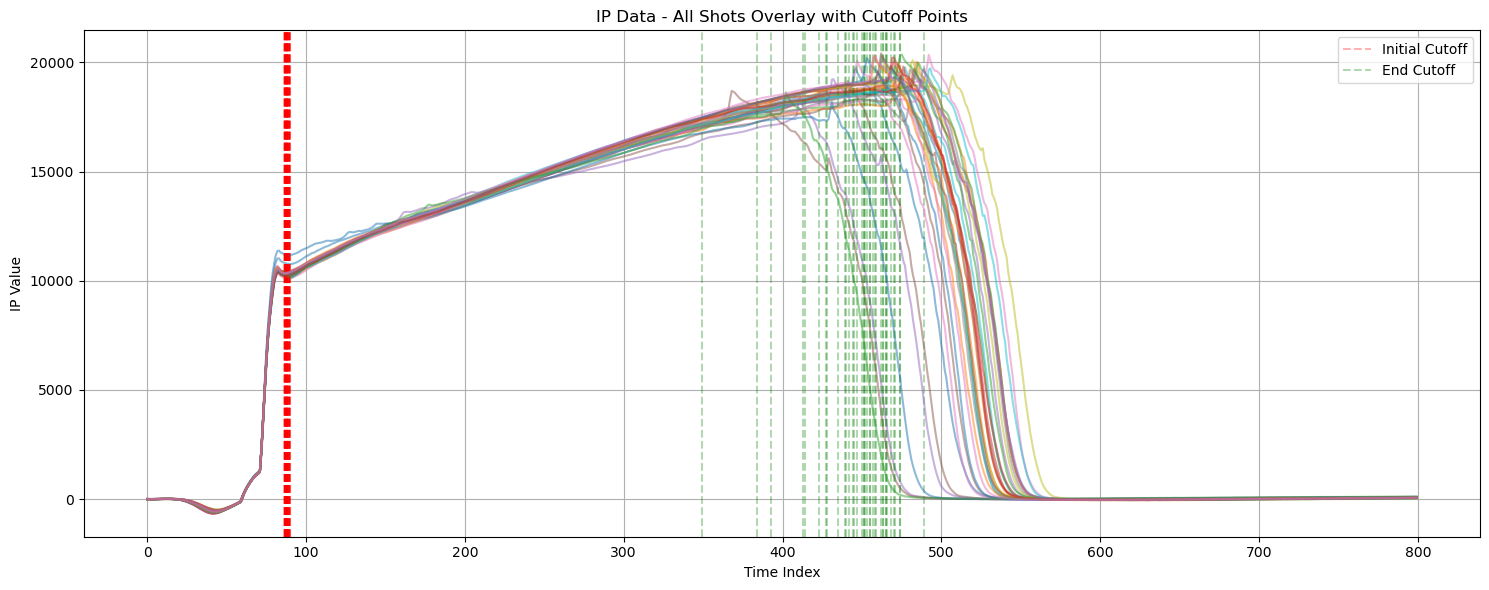

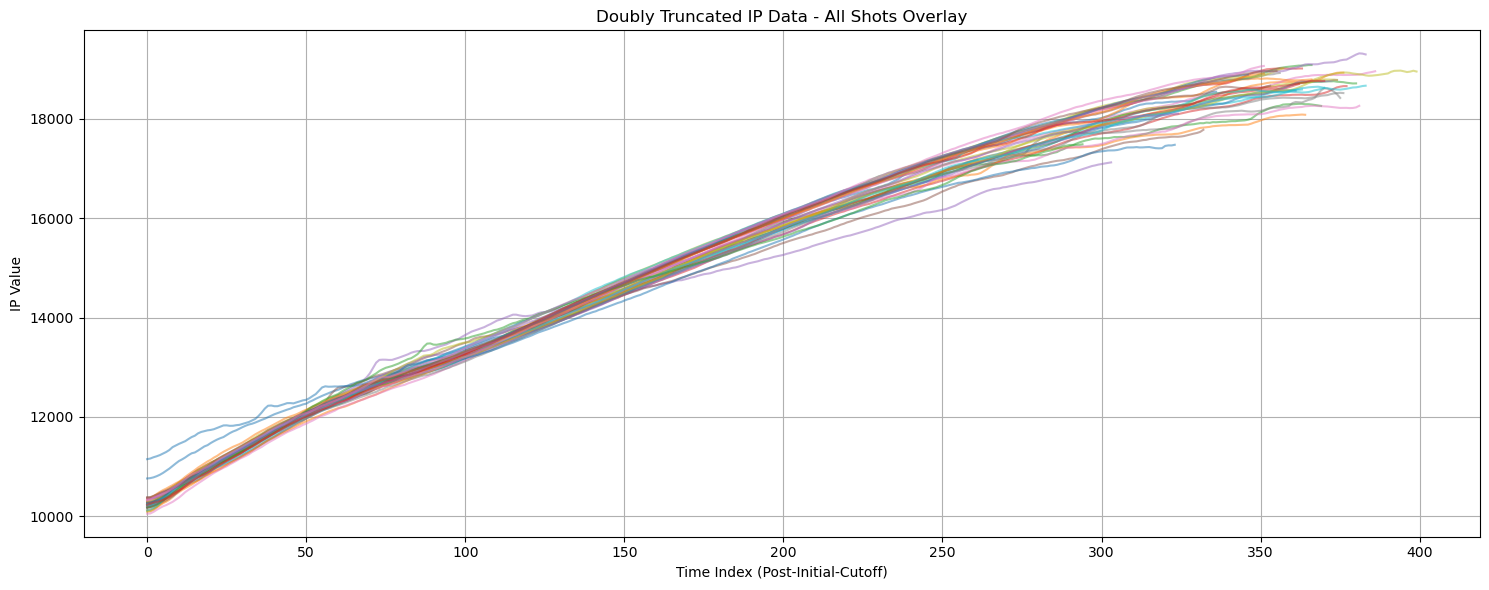

In [101]:
#Chopping up the shots by initial spikes and reducing frames!
#
# Window size for sensitivity
def find_cutoff_index(ip_data, window_size, start_index):
    """
    #Chopping up the shots by initial spikes by finding the cutoff!
    
    Parameters:
    - ip_data: 1D array of IP values for a single shot (e.g., formatted_ip_data[i, :, 0]).
    - window_size: Size of the moving average window for smoothing (5 seems fine).
    
    Returns:
    - cutoff_index: Index after which data should be included (before is the spike).
    """
    # Smooth the data with a moving average
    smoothed_ip = np.convolve(ip_data, np.ones(window_size)/window_size, mode='valid')
    # If points were removed from the smoothing, pad adds extra
    pad = window_size // 2
    smoothed_ip = np.pad(smoothed_ip, (pad, pad), mode='edge')
    # If padding adds too many, cut off to maintain size
    if len(smoothed_ip) > len(ip_data):
        smoothed_ip = smoothed_ip[:len(ip_data)]
    
    # Compute the difference (first derivative)
    diff = np.diff(smoothed_ip)
    
    # Find the first peak: where diff changes from positive to negative
    peak_index = None
    for i in range(50, len(diff)):
        if diff[i-1] > 0 and diff[i] < 0 and ip_data[i] > 0:
            peak_index = i
            break
    if peak_index is None:
        return 0  # No peak found, assume no spike or include all data
    
    # Find the next valley: where diff changes from negative to positive after peak
    valley_index = None
    for i in range(peak_index + 1, len(diff)):
        if diff[i-1] < 0 and diff[i] > 0 and ip_data[i] > 0:
            valley_index = i
            break
    if valley_index is None:
        return peak_index  # No valley found, cut after peak
    
    return valley_index

cutoff_indices = []
for i in range(len(shot_list)):
    ip = formatted_ip_data[i, :, 0]
    cutoff_index = find_cutoff_index(ip, window_size=5, start_index = 50)
    cutoff_indices.append(cutoff_index)
    #print(f"Shot {shot_list[i]}: Cutoff index = {cutoff_index}") # For viewing cutoff indexes

# Function to find end cutoff
def find_end_cutoff_index(ip_data, window_size=5, jump_ratio=2.5, lookback_window=10, stability_window=30):
    """
    Detect the cutoff index before a sudden jump at the end of the IP data, moving forward.
    
    Parameters:
    - ip_data: 1D array of IP values for a single shot (e.g., the truncated IP data).
    - window_size: Size of the moving average window for smoothing 
    - jump_ratio: Multiplier of the median derivative to detect a jump 
    - lookback_window: Number of frames to look back for the jump detection window 
    - stability_window: Number of frames to establish the baseline median derivative 
    
    Returns:
    - end_cutoff_index: Index before the sudden jump (relative to the start of ip_data).
    """
    # Smooth the data with a moving average
    smoothed_ip = np.convolve(ip_data, np.ones(window_size)/window_size, mode='valid')
    pad = window_size // 2
    smoothed_ip = np.pad(smoothed_ip, (pad, pad), mode='edge')
    if len(smoothed_ip) > len(ip_data):
        smoothed_ip = smoothed_ip[:len(ip_data)]
    
    # Compute the first derivative
    diff = np.diff(smoothed_ip)
    
    # Calculate the median derivative over the initial stability window as baseline
    if len(diff) > stability_window:
        baseline_median = np.median(diff[:stability_window])
    else:
        baseline_median = np.median(diff) if len(diff) > 0 else 0.0
    
    # Move forward to find the sudden jump
    for i in range(stability_window, len(diff) - lookback_window):
        # Look at the maximum derivative in the next lookback_window
        max_deriv = np.max(diff[i:i + lookback_window])
        if max_deriv > jump_ratio * abs(baseline_median) and diff[i] < max_deriv * 0.2:
            # Found the onset of a sudden jump; set cutoff before this point
            return max(0, i - window_size)  # Buffer to include some context
    return len(ip_data)  # No jump detected, use full length

# Calculate end cutoff indices for truncated data
end_cutoff_indices = []
for i in range(len(shot_list)):
    start_cutoff = cutoff_indices[i]
    truncated_ip = formatted_ip_data[i, start_cutoff:, 0]
    end_cutoff = find_end_cutoff_index(truncated_ip)
    end_cutoff_indices.append(end_cutoff + start_cutoff if end_cutoff < len(truncated_ip) else TARGET_FRAME_COUNT)
    #print(f"Shot {shot_list[i]}: End Cutoff index = {end_cutoff_indices[i]}")

# Plot all shots overlaid with cutoff points for validation
plt.figure(figsize=(15, 6))
for i, shot_num in enumerate(shot_list):
    plt.plot(formatted_ip_data[i, :, 0], alpha=0.5)
    plt.axvline(cutoff_indices[i], color='r', linestyle='--', alpha=0.3, label='Initial Cutoff' if i == 0 else "")
    plt.axvline(end_cutoff_indices[i], color='g', linestyle='--', alpha=0.3, label='End Cutoff' if i == 0 else "")
plt.title('IP Data - All Shots Overlay with Cutoff Points')
plt.xlabel('Time Index')
plt.ylabel('IP Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

'''
for i in range(min(5, len(shot_list))):
    plt.figure(figsize=(10, 4))
    plt.plot(formatted_ip_data[i, :, 0])
    plt.axvline(cutoff_indices[i], color='r', linestyle='--')
    plt.axvline(end_cutoff_indices[i], color='g', linestyle='--')
    plt.title(f'Shot {shot_list[i]}')
    plt.show()
'''

# Plot truncated IP data (post-initial-cutoff, pre-end-cutoff) overlaid
plt.figure(figsize=(15, 6))
for i, shot_num in enumerate(shot_list):
    start_cutoff = cutoff_indices[i]
    end_cutoff = end_cutoff_indices[i]
    truncated_ip = formatted_ip_data[i, start_cutoff:end_cutoff, 0]
    plt.plot(truncated_ip, alpha=0.5)
plt.title('Doubly Truncated IP Data - All Shots Overlay')
plt.xlabel('Time Index (Post-Initial-Cutoff)')
plt.ylabel('IP Value')
plt.grid(True)
plt.tight_layout()
plt.show()

IP normalization factor: 20411.82046537343
Training shape:  (26143, 32, 32, 1) Target shape:  (26143, 1)
Testing shape:  (200, 32, 32, 1) Testing label shape:  (200, 1)


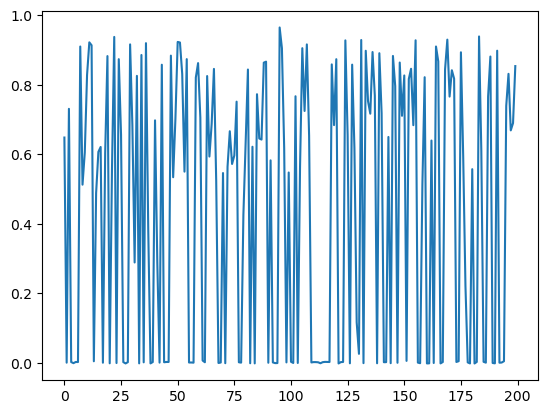

In [33]:
training_data_2D, cut_training_data_2D, flat_training_data = process_all_shots(shot_list, file_path_tiff)

# Look at cut_training_data_2D to check size
'''
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cut_training_data_2D[0, i, :, :], cmap='gray')  # Removed the extra channel index
    plt.title(f'Frame {i}')
    plt.axis('off')
plt.suptitle(f'Sample Images from Shot {shot_list[0]}')
plt.tight_layout()
plt.show()
'''

# Prepare data for IP prediction model
ip_target_data = formatted_ip_data
ip_training_data = cut_training_data_2D

# Calculate normalization factor for IP data

ip_norm_factor = np.max(np.abs(formatted_ip_data))
print(f"IP normalization factor: {ip_norm_factor}")

# Reshape and normalize the data
ip_target_vector = []
ip_training_vector = []
tot_frames = TARGET_FRAME_COUNT

for i in range(len(shot_list)):
    cutoff = cutoff_indices[i]
    for j in range(cutoff, tot_frames):
        # Normalize IP data
        ip_target_vector.append(ip_target_data[i][j] / ip_norm_factor)
        ip_training_vector.append(ip_training_data[i][j])

# Shuffle the data
random.seed(123)
zip_list = list(zip(ip_target_vector, ip_training_vector))
random.shuffle(zip_list)
ip_target_vector, ip_training_vector = zip(*zip_list)

# Convert to numpy arrays with explicit dtypes and shapes
ip_target_vector = np.asarray(ip_target_vector, dtype=np.float32)
ip_training_vector = np.asarray(ip_training_vector, dtype=np.float32)

# Ensure consistent shapes
ip_training_vector = ip_training_vector.reshape(-1, 32, 32, 1)
ip_target_vector = ip_target_vector.reshape(-1, 1)

# Split into training and testing sets
ip_testing_inputs = ip_training_vector[-201:-1]
ip_testing_labels = ip_target_vector[-201:-1]
ip_training_vector = ip_training_vector[0:-200]
ip_target_vector = ip_target_vector[0:-200]

# Convert to TensorFlow tensors with specified shapes
ip_training_vector = tf.convert_to_tensor(ip_training_vector, dtype=tf.float32)
ip_target_vector = tf.convert_to_tensor(ip_target_vector, dtype=tf.float32)
ip_testing_inputs = tf.convert_to_tensor(ip_testing_inputs, dtype=tf.float32)
ip_testing_labels = tf.convert_to_tensor(ip_testing_labels, dtype=tf.float32)

print('Training shape: ', ip_training_vector.shape, 'Target shape: ', ip_target_vector.shape)
print('Testing shape: ', ip_testing_inputs.shape, 'Testing label shape: ', ip_testing_labels.shape)
plt.plot(ip_testing_labels)

In [25]:
# Define model architecture parameters
num_conv2d_layers = 2
num_dense_layers = 1

conv2d_neurons = [16, 8]  # Number of filters in each Conv2D layer
conv2d_size = [(8, 8), (8, 8)]  # Kernel sizes for Conv2D layers
dense_layer_neurons = [24]  # Neurons in the dense layer
max_pooling_size = (4, 4)  # Pooling size for MaxPooling2D
activation_func = 'relu'  # Activation function for hidden layers
loss_func = 'mean_squared_error'  # Loss function for regression
optimizer_func = 'adam'  # Optimizer

# Create the model
ip_model = tf.keras.models.Sequential()

# Add input layer
ip_model.add(tf.keras.layers.InputLayer(shape=(32, 32, 1)))

# Add Conv2D and MaxPooling layers
for i in range(num_conv2d_layers):
    ip_model.add(tf.keras.layers.Conv2D(
        filters=conv2d_neurons[i],
        kernel_size=conv2d_size[i],
        strides=1,
        activation=activation_func,
    ))
    ip_model.add(tf.keras.layers.MaxPooling2D(
        pool_size=max_pooling_size,
        strides=1,
    ))

# Flatten the output
ip_model.add(tf.keras.layers.Flatten())

# Add dense layers
for i in range(num_dense_layers):
    ip_model.add(tf.keras.layers.Dense(
        units=dense_layer_neurons[i],
        activation=activation_func
    ))

# Output layer (single value for normalized IP prediction)
ip_model.add(tf.keras.layers.Dense(1))

# Compile the model
ip_model.compile(optimizer=optimizer_func, loss=loss_func)

# Display model summary
ip_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 8)      │         8,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │        27,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,937 (144.29 KB)

 Trainable params: 36,937 (144.29 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Training settings
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)

# Train the model with tf.data.Dataset
Model = ip_model
ip_history = Model.fit(ip_training_vector, ip_target_vector,
                    epochs=15,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1043 - val_loss: 0.0534
Epoch 2/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0552 - val_loss: 0.0505
Epoch 3/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0395 - val_loss: 0.0340
Epoch 4/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0323 - val_loss: 0.0286
Epoch 5/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0295 - val_loss: 0.0310
Epoch 6/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0271 - val_loss: 0.0261
Epoch 7/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0259 - val_loss: 0.0294
Epoch 8/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0263 - val_loss: 0.0231
Epoch 9/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0240 - val_loss: 0.0227
Epoch 10/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0236 - val_loss: 0.0232
Epoch 11/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0226 - val_loss: 0.0208
Epoch 12/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


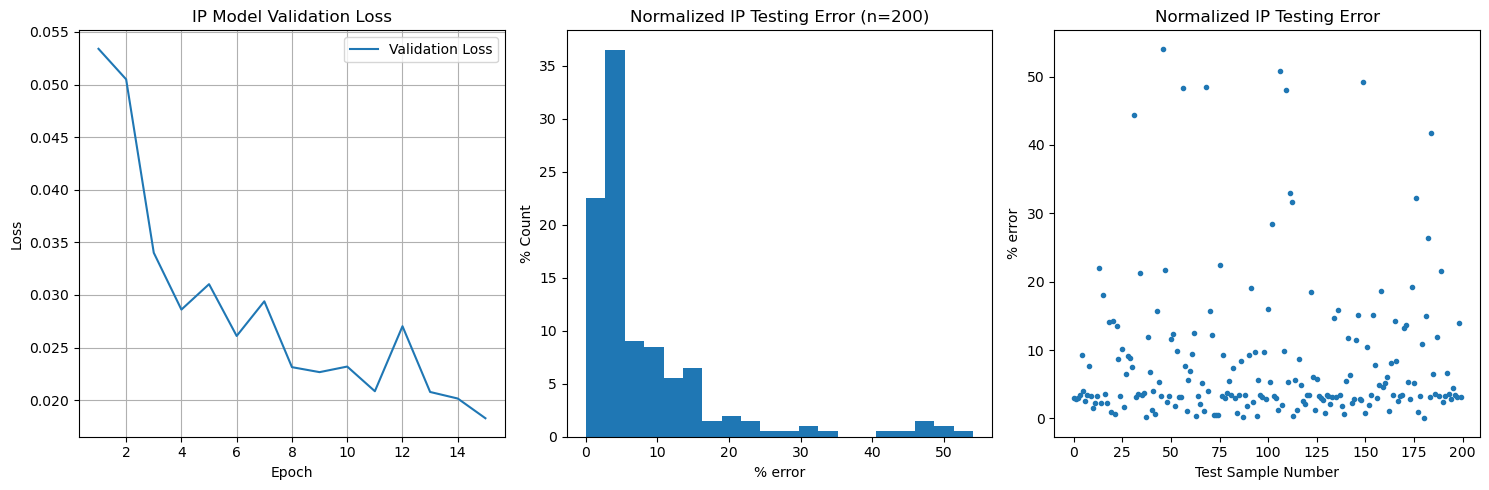

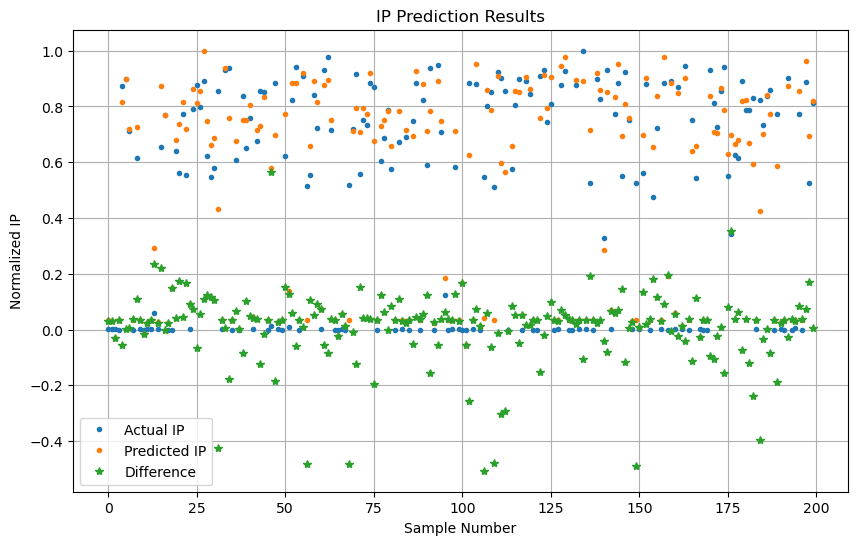

Maximum actual IP: 20112.98046875
Maximum predicted IP: 19213.43359375
Mean absolute percentage error: 8.33%


In [31]:
# Evaluate the model on test data
ip_predictions = Model.predict(ip_testing_inputs)

# Calculate prediction errors
ip_prediction_errors = abs((ip_testing_labels[:,0] - ip_predictions[:,0])) / tf.reduce_max(ip_testing_labels[:,0]) * 100

# Create visualization plots
fig, axes = plt.subplots(figsize=(15,5), ncols=3, nrows=1)

# Plot 1: Training History
axes[0].plot(range(1,len(ip_history.history['val_loss'])+1), 
             ip_history.history['val_loss'], 
             label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('IP Model Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Error Distribution
weights = np.ones_like(ip_prediction_errors) / len(ip_prediction_errors) * 100
axes[1].hist(ip_prediction_errors, 20, weights=weights)
axes[1].set_xlabel('% error')
axes[1].set_ylabel('% Count')
axes[1].set_title('Normalized IP Testing Error (n=200)')

# Plot 3: Error by Sample
axes[2].plot(ip_prediction_errors, '.')
axes[2].set_xlabel('Test Sample Number')
axes[2].set_ylabel('% error')
axes[2].set_title('Normalized IP Testing Error')

plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(ip_testing_labels[:,0]/tf.reduce_max(ip_testing_labels[:,0]), '.', label='Actual IP')
plt.plot(ip_predictions[:,0]/tf.reduce_max(ip_predictions[:,0]), '.', label='Predicted IP')
plt.plot(-(ip_testing_labels[:,0]/tf.reduce_max(ip_testing_labels[:,0]) - 
           ip_predictions[:,0]/tf.reduce_max(ip_predictions[:,0])), '*', label='Difference')
plt.xlabel('Sample Number')
plt.ylabel('Normalized IP')
plt.title('IP Prediction Results')
plt.legend()
plt.grid(True)
plt.show()

print(f"Maximum actual IP: {tf.reduce_max(ip_testing_labels[:,0]) * ip_norm_factor}")
print(f"Maximum predicted IP: {tf.reduce_max(ip_predictions[:,0]) * ip_norm_factor}")
print(f"Mean absolute percentage error: {tf.reduce_mean(ip_prediction_errors):.2f}%")
